In [1]:
import tstrain
import tsclust
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [3]:
### Create ndvi bands for each date in Sentinel-2 asset dataset ###

# File path containing Sentinel-2 bands intersecting with AOI, organized by date 
#fp = '/home/ec2-user/Sentinel-2A' # <- all bands all dates
fp = '/home/ec2-user/prediction_scenes/Sentinel-2A' # <- First 6 dates only; NDVI, green and blue bands 

# Band dictionary to match asset names with variables
asset_dict = {'B02': 'blue',
              'B03': 'green',
              'B04': 'red',
              'B08': 'nir'}

# For now, create ndvi index only
#indices = ['ndvi']

In [3]:
# # Perform calculation and save images to appropriate directory
# tstrain.calulate_indices(fp, asset_dict, indices)

In [4]:
# Clustered NDVI time-series data for cropped area; 5 clusters
clust5 = pd.read_csv('/home/ec2-user/sample/5_clusters.csv')
clust5.shape

(10000, 82)

In [5]:
# Combine samples from clustered cropped area, and other land cover classes into single dataset
# for model fitting. `lcts` is file path to .csv files containing NDVI time-series' from vegetation,
# urban, and water land cover classes.
lcts = '/home/ec2-user/sample/land_cover_samples'

# Take n_samples of each non-crop land cover class
noncrop_samples = tstrain.random_ts_samples(lcts, n_samples=10000, seed=0)

# Rename and drop columns to allow concatination of crop and non-crop samples
clust5 = clust5.rename(columns={'cluster': 'label'})
clust5 = clust5.drop(['lc'], axis=1)

# Combine datasets
dlist = [clust5, noncrop_samples]
allsamples = pd.concat(dlist, ignore_index=True)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  from ipykernel import kernelapp as app


In [6]:
# Using raster index locations from `allsamples` (Step 1), extract band reflectance values from a time-series of 
# scenes contained in a directory generated using the default sat-search directory structure

# Extract training data from Sentinel-2 time-series
training_data = tstrain.get_training_data(fp, asset_dict, allsamples, standardize=False)

In [7]:
i = training_data.set_index(['date', 'ind', 'feature'])
i.head(20)

value label
date       ind          feature              
2016-11-16 (2428, 4479) blue     0.1081   veg
                        green    0.1010   veg
                        ndvi     0.2294   veg
2017-02-14 (2428, 4479) blue     0.0854   veg
                        green    0.0870   veg
                        ndvi     0.6892   veg
2017-04-05 (2428, 4479) blue     0.0766   veg
                        green    0.0841   veg
                        ndvi     0.7618   veg
2017-05-05 (2428, 4479) blue     0.0815   veg
                        green    0.0804   veg
                        ndvi     0.7272   veg
2017-05-15 (2428, 4479) blue     0.0772   veg
                        green    0.0740   veg
                        ndvi     0.7265   veg
2017-05-25 (2428, 4479) blue     0.0760   veg
                        green    0.0706   veg
                        ndvi     0.6695   veg
2016-11-16 (2429, 4441) blue     0.1048   veg
                        green    0.0963   veg

In [11]:
#training_data.to_csv('/home/ec2-user/training_data.csv')
#training_data.to_csv('/home/ec2-user/training_data_few_bands.csv')

In [8]:
# Use first 7 dates in time series (Nov 16, 2016 through June 6, 2017)
dates = training_data.date.unique()
datesub = dates[0:6]
trainsub = training_data[training_data['date'].isin(datesub)]

In [9]:
datesub

array(['2016-11-16', '2017-02-14', '2017-04-05', '2017-05-05',
       '2017-05-15', '2017-05-25'], dtype=object)

In [10]:
# Fit a LSTM recurrent neural network. In this 'toy' example, a total of 25,000 samples are used to fit a model.
# including 10,000 from the clustered "cropped" class, and 5,000 from each of the "water", "urban" and
# "vegetation" classes. The bands (features) include red, blue, green, and nir. Y labels are numerically
# encoded, and converted to "one-hot" vectors.

# Format training data into correct 3D array of shape (n_samples, n_timesetps, n_features) required to fit a
# Keras LSTM model. N_features corresponds to number of bands included in training data

class_codes, x, y = tstrain.format_training_data(trainsub)

In [12]:
class_codes

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 'urban', 6: 'veg', 7: 'water'}

In [14]:
# Split training and test data
x_train, x_test, y_train, y_test = tstrain.split_train_test(x, y, seed=0)

In [16]:
# def standardize_features(x_train, x_test):
#     '''Standardize features of 3D array formated for keras sequential model'''

#     mu = x_train.mean(axis=(0, 1))
#     sd = x_train.std(axis=(0, 1))

#     x_train_norm = (x_train - mu) / sd
#     x_test_norm = (x_test - mu) / sd

#     return mu, sd, x_train_norm, x_test_norm

In [15]:
# Standardize features
mu, sd, x_train_norm, x_test_norm = tstrain.standardize_features(x_train, x_test)

In [17]:
# Train LSTM model
n_timesteps = len(trainsub['date'].unique())
n_features = len(trainsub['feature'].unique())

model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32))
model.add(Dense(activation='softmax', units=y.shape[1]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.fit(x_train_norm, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
 - 24s - loss: 0.6634 - categorical_accuracy: 0.7589
Epoch 2/50
 - 21s - loss: 0.4108 - categorical_accuracy: 0.8467
Epoch 3/50
 - 21s - loss: 0.3545 - categorical_accuracy: 0.8662
Epoch 4/50
 - 21s - loss: 0.3263 - categorical_accuracy: 0.8755
Epoch 5/50
 - 21s - loss: 0.3030 - categorical_accuracy: 0.8853
Epoch 6/50
 - 21s - loss: 0.2863 - categorical_accuracy: 0.8896
Epoch 7/50
 - 21s - loss: 0.2685 - categorical_accuracy: 0.8964
Epoch 8/50
 - 21s - loss: 0.2539 - categorical_accuracy: 0.9024
Epoch 9/50
 - 21s - loss: 0.2416 - categorical_accuracy: 0.9057
Epoch 10/50
 - 21s - loss: 0.2365 - categorical_accuracy: 0.9074
Epoch 11/50
 - 21s - loss: 0.2256 - categorical_accuracy: 0.9119
Epoch 12/50
 - 21s - loss: 0.2214 - categorical_accuracy: 0.9129
Epoch 13/50
 - 21s - loss: 0.2125 - categorical_accuracy: 0.9166
Epoch 14/50
 - 21s - loss: 0.2071 - categorical_accuracy: 0.9188
Epoch 15/50
 - 21s - loss: 0.2015 - categorical_accuracy: 0.9212
Epoch 16/50
 - 21s - loss: 0.1958 

In [18]:
# Model accuracy
_, accuracy = model.evaluate(x_test_norm, y_test, batch_size=32)
accuracy

7191/7191 [==============================] - 2s 215us/step


0.9413155333055208

In [19]:
# Confusion matrix
tstrain.conf_mat(x_test_norm, y_test, model, class_codes)

,0,1,2,3,4,urban,veg,water,recall
0,377,33,3,1,0,6,2,0,0.893365
1,72,325,16,6,10,0,2,0,0.754060
2,18,25,453,1,63,1,2,0,0.804618
3,5,8,1,57,0,0,0,0,0.802817
4,11,13,101,2,350,0,12,0,0.715746
urban,7,3,0,0,0,1179,1,0,0.990756
veg,5,2,1,0,8,1,1985,0,0.991508
water,0,0,0,0,0,0,0,2023,1.000000


In [20]:
# serialize model to JSON
model_json = model.to_json()
with open("/home/ec2-user/model_improved.json", "w") as json_file:
    json_file.write(model_json)

In [21]:
# serialize weights to HDF5
model.save_weights("/home/ec2-user/model.h5")
print("Saved model to disk")

Saved model to disk


/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


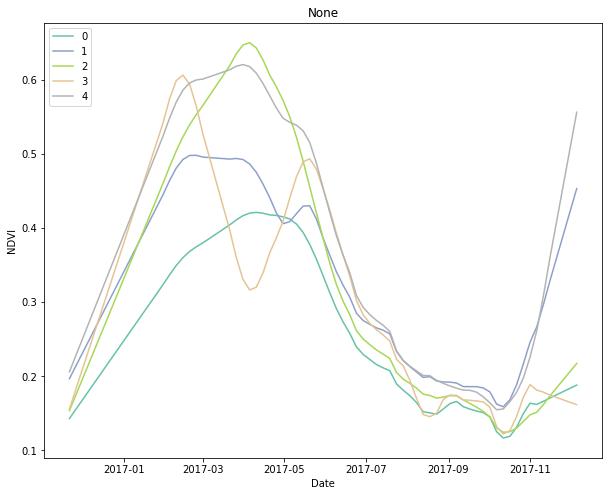

In [22]:
cropclusts = clust5.rename(columns={'label': 'cluster'})
tsclust.plot_clusters(cropclusts, fill=False)